
\begin{align}
    \beta &\sim \text{Beta}(2,5) ; \;  
    \gamma \sim \text{Beta}(2,8) \\ 
    S_{0}&=990 ; I_{0} = 10; R_{0} = 0\\
    S,I,R,\Delta I &= ODE( [S_{0},I_{0}, R_{0}; \beta, \gamma]  ) \\ 
    (\Delta i)_{t} &\sim \text{Pois}( \Delta I_{t} )
\end{align}

\begin{align}
    p( \beta, \gamma | \mathcal{D} ) = \frac{p(\mathcal{D} |\beta, \gamma ) p(\beta, \gamma)}{ \int_{\beta=0}^{\infty} \int_{\gamma=0}^{\infty} p(\mathcal{D} |\beta, \gamma ) p(\beta, \gamma) \; d \gamma d \beta } \\ 
\end{align}

\begin{align}
    p(\mathcal{D} |\beta, \gamma ) = \text{Pois}( \Delta I_{1} )[(\Delta i)_{1}] \times \text{Pois}( \Delta I_{2} )[(\Delta i)_{2}] \times \cdots \times  \text{Pois}( \Delta I_{T} )[(\Delta i)_{T}] = \prod_{t=1}^{T} \text{Pois}( \Delta I_{t} )[(\Delta i)_{t}] \\ 
\end{align}

\begin{align}
    p(\beta, \gamma) &= p(\beta) \times p(\gamma) \\ 
    &= \frac{1}{\text{Beta}(2,5)} \beta^{2-1} (1-\beta)^{5-1} \times  \frac{1}{\text{Beta}(2,8)} \gamma^{2-1} (1-\gamma)^{8-1}
\end{align}


\begin{align}
    p(\mathcal{D} |\beta, \gamma )  &= \prod_{t=1}^{T} \text{Pois}( \Delta I_{t} )[(\Delta i)_{t}] \times \left[ \frac{1}{\text{Beta}(2,5)} \beta^{2-1} (1-\beta)^{5-1} \times  \frac{1}{\text{Beta}(2,8)} \gamma^{2-1} (1-\gamma)^{8-1} \right]
\end{align}

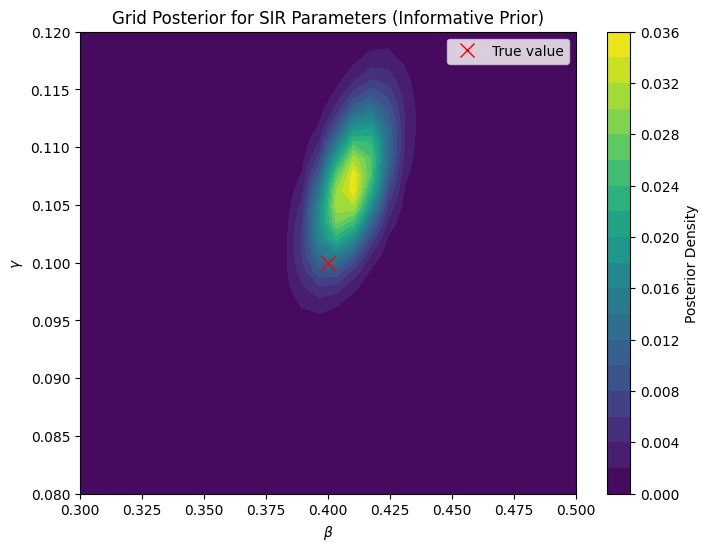

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

# Simulate "true" data
beta_true = 0.4
gamma_true = 0.1
N = 1000
I0 = 10
R0 = 0
S0 = N - I0 - R0
T = 30

S = [S0]
I = [I0]
R = [R0]

for t in range(T):
    new_infected = beta_true * S[-1] * I[-1] / N
    new_recovered = gamma_true * I[-1]
    
    S.append(S[-1] - new_infected)
    I.append(I[-1] + new_infected - new_recovered)
    R.append(R[-1] + new_recovered)

sigma = 50
I_obs = np.array(I) + np.random.normal(0, sigma, size=(T+1,))

# Define grid
beta_grid = np.linspace(0.3, 0.5, 30)
gamma_grid = np.linspace(0.08, 0.12, 30)

posterior = np.zeros((len(beta_grid), len(gamma_grid)))

# Prior distributions
beta_prior = scipy.stats.beta(2,5)
gamma_prior = scipy.stats.beta(2,8)

# Evaluate posterior
for i, beta in enumerate(beta_grid):
    for j, gamma in enumerate(gamma_grid):
        
        # simulate model
        S_pred = [S0]
        I_pred = [I0]
        R_pred = [R0]
        
        for t in range(T):
            new_infected = beta * S_pred[-1] * I_pred[-1] / N
            new_recovered = gamma * I_pred[-1]
            
            S_pred.append(S_pred[-1] - new_infected)
            I_pred.append(I_pred[-1] + new_infected - new_recovered)
            R_pred.append(R_pred[-1] + new_recovered)
        
        I_pred = np.array(I_pred)
        
        # likelihood
        log_likelihood = np.sum(scipy.stats.norm(I_pred, sigma).logpdf(I_obs))
        
        # prior
        log_prior_beta = beta_prior.logpdf(beta)
        log_prior_gamma = gamma_prior.logpdf(gamma)
        
        log_prior = log_prior_beta + log_prior_gamma
        
        posterior[i,j] = np.exp(log_likelihood + log_prior)

# Normalize posterior
posterior /= np.sum(posterior)

# Plot posterior
plt.figure(figsize=(8,6))
B, G = np.meshgrid(beta_grid, gamma_grid, indexing='ij')
plt.contourf(B, G, posterior, levels=20)
plt.xlabel(r'$\beta$')
plt.ylabel(r'$\gamma$')
plt.title('Grid Posterior for SIR Parameters (Informative Prior)')
plt.colorbar(label='Posterior Density')
plt.plot(beta_true, gamma_true, 'rx', markersize=10, label='True value')
plt.legend()
plt.show()